# Predicting Open-Source Project Success

## Using Early Activity Signals to Forecast GitHub Repository Growth

**Author:** Jamiu Olamilekan Badmus  
**Email:** jamiubadmus001@gmail.com  
**LinkedIn:** [Jamiu Olamilekan Badmus](https://www.linkedin.com/in/jamiu-olamilekan-badmus-9276a8192/)  
**GitHub:** [jamiubadmusng](https://github.com/jamiubadmusng)  

---

## Project Overview

The open-source software ecosystem has grown exponentially over the past decade, with millions of new repositories created annually on GitHub. For technology companies, venture capitalists, and developer communities, identifying which projects will gain traction early in their lifecycle presents a significant opportunity. Early detection of promising projects enables strategic investment decisions, partnership opportunities, and resource allocation for open-source program offices.

This project develops a machine learning model to predict whether a newly created GitHub repository will become successful within six months, using only activity data from the first 30 days after creation. The model serves as a practical tool for:

- **Technology scouts** evaluating emerging tools and frameworks
- **Open-source program offices** identifying projects for sponsorship
- **Developers** deciding which projects to contribute to
- **Researchers** studying software ecosystem dynamics

### Data Source

The dataset was extracted from [GH Archive](https://www.gharchive.org/), a comprehensive record of public GitHub activity since 2011. GH Archive captures every public event on GitHub, including pushes, pull requests, issues, comments, stars, and forks. The raw archive contains over 17 terabytes of JSON data, making it one of the largest publicly available datasets on software development activity.

For this analysis, data was queried from Google BigQuery's public GH Archive dataset, focusing on repositories created in Q1 2024 and tracking their activity through Q3 2024.

### Research Question

> **Can we predict which open-source projects will become successful within six months using only their first 30 days of activity data?**

### Success Definition

A repository is classified as "successful" if it meets any of the following criteria by the six-month mark:

1. Accumulates 50 or more stars (indicating community interest)
2. Attracts 3 or more unique contributors AND shows continued development activity in months 4-6 (indicating sustainable growth)

## Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Feature Engineering](#4-feature-engineering)
5. [Model Development](#5-model-development)
6. [Model Evaluation](#6-model-evaluation)
7. [Feature Importance Analysis](#7-feature-importance-analysis)
8. [Business Insights and Recommendations](#8-business-insights-and-recommendations)
9. [Conclusion](#9-conclusion)

---

## 1. Setup and Data Loading

This section imports the required libraries and loads the dataset extracted from BigQuery.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, accuracy_score,
    precision_score, recall_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model interpretation
import shap

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# Load the dataset
DATA_PATH = '../data/raw/github_projects_dataset.csv'
df = pd.read_csv(DATA_PATH)

print(f"Dataset loaded successfully.")
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")

Dataset loaded successfully.
Total records: 34,664
Total features: 40


In [3]:
# Initial inspection of the data
df.head()

,repo_id,repo_name,primary_language,description,repo_created_at,creator_id,creator_login,push_events_30d,total_commits_30d,issue_events_30d,issues_opened_30d,issues_closed_30d,issue_comments_30d,pr_events_30d,prs_opened_30d,prs_closed_30d,pr_reviews_30d,stars_30d,forks_30d,unique_contributors_30d,unique_committers_30d,events_week_1,events_week_2,events_week_3,events_week_4,total_events_30d,total_stars_6m,total_forks_6m,total_contributors_6m,total_committers_6m,pushes_months_4_to_6,issues_months_4_to_6,prs_months_4_to_6,contributors_months_4_to_6,total_releases_6m,total_events_6m,is_starred_project,has_community,is_actively_maintained,is_successful_project
0,771302083,OpenDevin/OpenDevin,NaN,NaN,2024-03-13 03:33:32.000000 UTC,13436140,huybery,453,856,1011,532,458,3515,828,419,405,708,20202,2165,21556,10,2555,6407,13535,6968,29465,30309,3627,32502,22,2234,597,2067,4693,12,68568,1,1,1,1
1,743230067,RVC-Boss/GPT-SoVITS,NaN,NaN,2024-01-14 18:05:22.000000 UTC,129054828,RVC-Boss,245,429,487,299,182,1350,287,156,129,1,9909,1022,10488,1,5218,3738,2734,1626,13316,28300,3253,29947,1,52,383,139,7743,0,37943,1,1,1,1
2,737898780,maybe-finance/maybe,NaN,NaN,2024-01-01 22:23:47.000000 UTC,35243,Shpigford,146,374,158,90,66,541,224,115,107,188,13137,932,13620,2,180,10131,4338,877,15526,27744,2209,28660,4,337,171,354,2638,9,35731,1,1,1,1
3,738733003,danielmiessler/fabric,NaN,NaN,2024-01-03 23:18:32.000000 UTC,50654,danielmiessler,241,251,28,14,14,49,27,14,13,3,3907,289,4075,2,86,153,174,4136,4549,17522,1772,18563,3,149,213,205,9143,8,22254,1,1,1,1
4,770153867,harry0703/MoneyPrinterTurbo,NaN,NaN,2024-03-11 02:57:34.000000 UTC,4928832,harry0703,89,136,375,195,177,634,33,14,17,3,8553,1241,9244,1,269,1267,6954,2448,10938,15903,2458,17199,3,30,107,36,2916,5,20474,1,1,1,1


In [4]:
# Data types and memory usage
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 34664 entries, 0 to 34663
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   repo_id                     34664 non-null  int64  
 1   repo_name                   34664 non-null  str    
 2   primary_language            0 non-null      float64
 3   description                 0 non-null      float64
 4   repo_created_at             34664 non-null  str    
 5   creator_id                  34664 non-null  int64  
 6   creator_login               34664 non-null  str    
 7   push_events_30d             34664 non-null  int64  
 8   total_commits_30d           34664 non-null  int64  
 9   issue_events_30d            34664 non-null  int64  
 10  issues_opened_30d           34664 non-null  int64  
 11  issues_closed_30d           34664 non-null  int64  
 12  issue_comments_30d          34664 non-null  int64  
 13  pr_events_30d               34664 non-null

In [5]:
# Statistical summary of numeric features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
repo_id,34664.0,7.601027e+08,1.209646e+07,737654913.0,750286007.0,760271490.0,7.706529e+08,780185590.0
primary_language,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
creator_id,34664.0,8.977269e+07,5.850118e+07,80.0,34826627.0,91976876.0,1.539479e+08,165597113.0
push_events_30d,34664.0,3.984664e+01,1.862375e+03,0.0,1.0,3.0,1.300000e+01,320639.0
total_commits_30d,34664.0,7.023373e+01,2.408744e+03,0.0,1.0,3.0,1.600000e+01,320639.0
issue_events_30d,34664.0,1.748471e+00,1.312371e+01,0.0,0.0,0.0,0.000000e+00,1011.0
issues_opened_30d,34664.0,1.103393e+00,7.724928e+00,0.0,0.0,0.0,0.000000e+00,532.0
issues_closed_30d,34664.0,6.194323e-01,5.619290e+00,0.0,0.0,0.0,0.000000e+00,474.0
issue_comments_30d,34664.0,2.780118e+00,3.402210e+01,0.0,0.0,0.0,0.000000e+00,3515.0


---

## 2. Exploratory Data Analysis

This section examines the distribution of features, class balance, and relationships between variables to inform modeling decisions.

### 2.1 Target Variable Distribution

Understanding the class balance is critical for selecting appropriate modeling techniques and evaluation metrics.

In [6]:
# Target variable distribution
target_dist = df['is_successful_project'].value_counts()
target_pct = df['is_successful_project'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"  Not Successful (0): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
print(f"  Successful (1): {target_dist[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_dist[0]/target_dist[1]:.2f}:1")

Target Variable Distribution:
  Not Successful (0): 19,578 (56.48%)
  Successful (1): 15,086 (43.52%)

Class Imbalance Ratio: 1.30:1


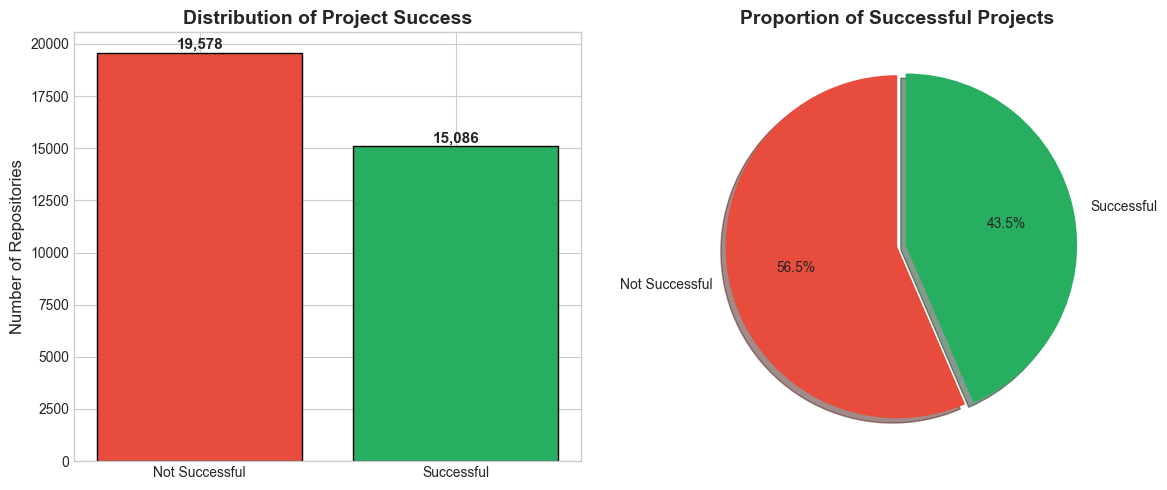

In [7]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#e74c3c', '#27ae60']
bars = axes[0].bar(['Not Successful', 'Successful'], target_dist.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Number of Repositories', fontsize=12)
axes[0].set_title('Distribution of Project Success', fontsize=14, fontweight='bold')
for bar, count in zip(bars, target_dist.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
                 f'{count:,}', ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(target_dist.values, labels=['Not Successful', 'Successful'], 
            autopct='%1.1f%%', colors=colors, explode=[0, 0.05],
            shadow=True, startangle=90)
axes[1].set_title('Proportion of Successful Projects', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/figures/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Programming Language Distribution

Examining which programming languages are most common and their relationship with project success.

In [11]:
# Check programming language availability
language_null_count = df['primary_language'].isna().sum()
print(f"Programming language data availability: {len(df) - language_null_count:,} of {len(df):,} records ({(1 - language_null_count/len(df))*100:.1f}%)")

if language_null_count < len(df):
    # Top programming languages
    language_counts = df['primary_language'].value_counts().head(15)
    
    # Create a DataFrame for plotly
    lang_df = pd.DataFrame({'language': language_counts.index, 'count': language_counts.values})
    
    fig = px.bar(
        lang_df,
        x='language',
        y='count',
        labels={'language': 'Programming Language', 'count': 'Number of Repositories'},
        title='Top 15 Programming Languages by Repository Count',
        color='count',
        color_continuous_scale='viridis'
    )
    fig.update_layout(showlegend=False, xaxis_tickangle=-45)
    fig.show()
else:
    print("\\nNote: Programming language data is not available in this dataset.")
    print("The analysis will proceed using activity-based features only.")
    print("This does not affect the predictive modeling as language is a secondary feature.")

Programming language data availability: 0 of 34,664 records (0.0%)
\nNote: Programming language data is not available in this dataset.
The analysis will proceed using activity-based features only.
This does not affect the predictive modeling as language is a secondary feature.


In [12]:
# Success rate by programming language (top 10) - if data is available
if df['primary_language'].notna().sum() > 0:
    top_languages = df['primary_language'].value_counts().head(10).index.tolist()
    lang_success = df[df['primary_language'].isin(top_languages)].groupby('primary_language')['is_successful_project'].agg(['sum', 'count'])
    lang_success['success_rate'] = (lang_success['sum'] / lang_success['count'] * 100).round(2)
    lang_success = lang_success.sort_values('success_rate', ascending=False)
    
    # Create DataFrame for plotly
    lang_success_df = lang_success.reset_index()
    
    fig = px.bar(
        lang_success_df,
        x='primary_language',
        y='success_rate',
        labels={'primary_language': 'Programming Language', 'success_rate': 'Success Rate (%)'},
        title='Project Success Rate by Programming Language (Top 10)',
        color='success_rate',
        color_continuous_scale='RdYlGn'
    )
    fig.update_layout(showlegend=False, xaxis_tickangle=-45)
    fig.show()
    
    print("\\nSuccess Rate by Language:")
    print(lang_success[['count', 'sum', 'success_rate']].rename(columns={'count': 'total_repos', 'sum': 'successful', 'success_rate': 'success_rate_%'}))
else:
    print("Programming language data not available - skipping language-based analysis.")
    print("\\nAlternative Analysis: Success Rate by Activity Level")
    
    # Create activity level categories
    df['activity_level'] = pd.cut(df['total_events_30d'], 
                                   bins=[0, 10, 50, 100, 500, float('inf')],
                                   labels=['Very Low (1-10)', 'Low (11-50)', 'Medium (51-100)', 
                                          'High (101-500)', 'Very High (500+)'])
    
    activity_success = df.groupby('activity_level', observed=True)['is_successful_project'].agg(['sum', 'count'])
    activity_success['success_rate'] = (activity_success['sum'] / activity_success['count'] * 100).round(2)
    
    print("\\nSuccess Rate by Activity Level:")
    print(activity_success.rename(columns={'count': 'total_repos', 'sum': 'successful', 'success_rate': 'success_rate_%'}))

Programming language data not available - skipping language-based analysis.
\nAlternative Analysis: Success Rate by Activity Level
\nSuccess Rate by Activity Level:
                  successful  total_repos  success_rate_%
activity_level                                           
Very Low (1-10)         1160         3229           35.92
Low (11-50)             4279        19389           22.07
Medium (51-100)         4017         5538           72.54
High (101-500)          4875         5645           86.36
Very High (500+)         755          863           87.49


### 2.3 Early Activity Patterns

Analyzing the distribution of early-stage activity metrics that will serve as predictive features.

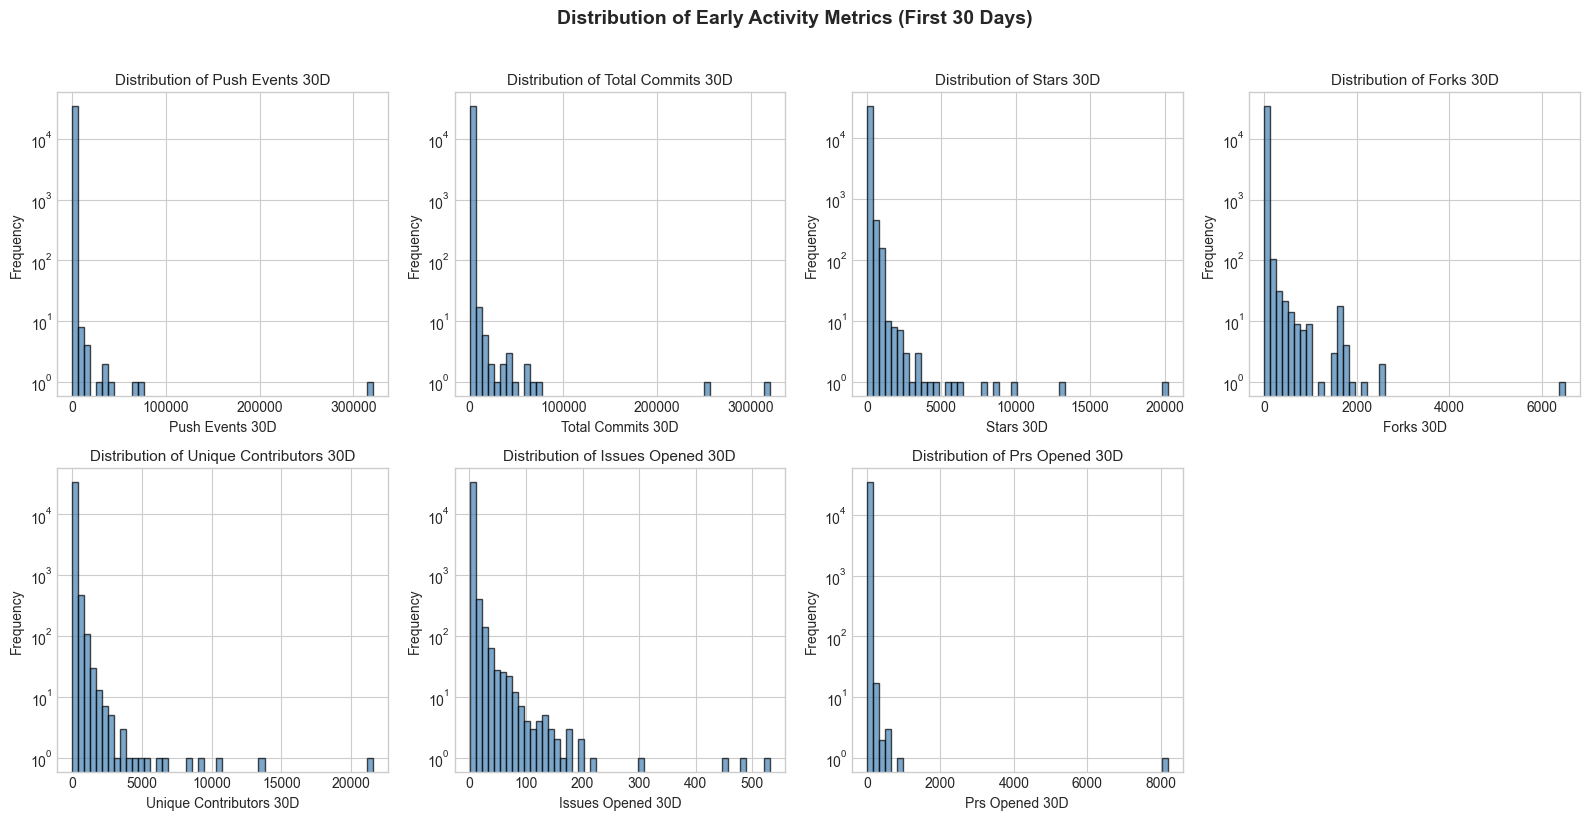

In [13]:
# Distribution of key early activity features
early_features = ['push_events_30d', 'total_commits_30d', 'stars_30d', 'forks_30d', 
                  'unique_contributors_30d', 'issues_opened_30d', 'prs_opened_30d']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(early_features):
    # Using log scale for better visualization of skewed distributions
    data = df[feature].replace(0, 0.1)  # Replace zeros for log scale
    axes[i].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=11)

# Remove extra subplot
axes[-1].axis('off')

plt.suptitle('Distribution of Early Activity Metrics (First 30 Days)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/early_activity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

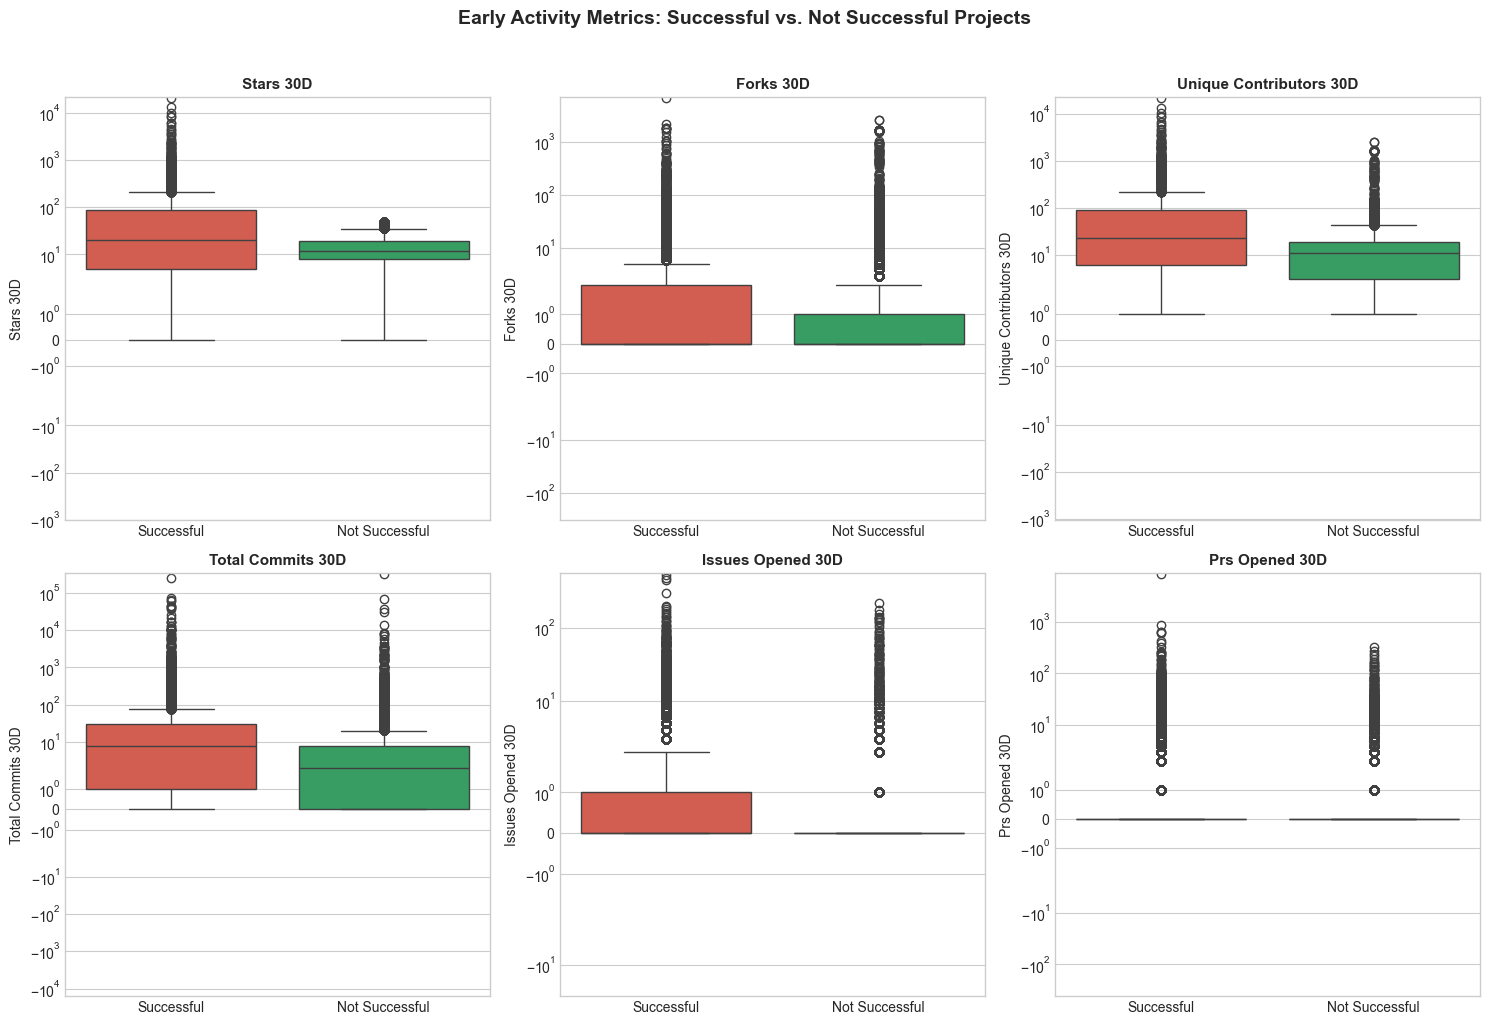

In [14]:
# Compare early activity between successful and unsuccessful projects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

comparison_features = ['stars_30d', 'forks_30d', 'unique_contributors_30d', 
                       'total_commits_30d', 'issues_opened_30d', 'prs_opened_30d']

for i, feature in enumerate(comparison_features):
    # Box plot comparing successful vs unsuccessful
    df_plot = df[[feature, 'is_successful_project']].copy()
    df_plot['is_successful_project'] = df_plot['is_successful_project'].map({0: 'Not Successful', 1: 'Successful'})
    
    sns.boxplot(data=df_plot, x='is_successful_project', y=feature, ax=axes[i],
                palette=['#e74c3c', '#27ae60'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
    axes[i].set_title(f'{feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    
    # Use log scale for y-axis if data is highly skewed
    if df[feature].max() > 100:
        axes[i].set_yscale('symlog')

plt.suptitle('Early Activity Metrics: Successful vs. Not Successful Projects', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/success_comparison_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 Weekly Activity Trends

Examining how activity evolves during the first four weeks and its relationship with eventual success.

In [15]:
# Weekly activity trends by success status
weekly_cols = ['events_week_1', 'events_week_2', 'events_week_3', 'events_week_4']

# Calculate mean weekly activity by success status
weekly_success = df[df['is_successful_project'] == 1][weekly_cols].mean()
weekly_fail = df[df['is_successful_project'] == 0][weekly_cols].mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['Week 1', 'Week 2', 'Week 3', 'Week 4'],
    y=weekly_success.values,
    mode='lines+markers',
    name='Successful Projects',
    line=dict(color='#27ae60', width=3),
    marker=dict(size=10)
))

fig.add_trace(go.Scatter(
    x=['Week 1', 'Week 2', 'Week 3', 'Week 4'],
    y=weekly_fail.values,
    mode='lines+markers',
    name='Not Successful Projects',
    line=dict(color='#e74c3c', width=3),
    marker=dict(size=10)
))

fig.update_layout(
    title='Average Weekly Activity Trends (First 30 Days)',
    xaxis_title='Week',
    yaxis_title='Average Number of Events',
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
)

fig.show()

### 2.5 Correlation Analysis

Examining correlations between features and the target variable to identify the most predictive signals.

In [16]:
# Select numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove identifier columns and target-related columns for feature correlation
exclude_cols = ['repo_id', 'creator_id', 'is_starred_project', 'has_community', 
                'is_actively_maintained', 'total_stars_6m', 'total_forks_6m',
                'total_contributors_6m', 'total_committers_6m', 'pushes_months_4_to_6',
                'issues_months_4_to_6', 'prs_months_4_to_6', 'contributors_months_4_to_6',
                'total_releases_6m', 'total_events_6m']

feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlation with target
correlations = df[feature_cols].corrwith(df['is_successful_project']).sort_values(ascending=False)

print("Feature Correlations with Project Success:")
print("=" * 50)
for feature, corr in correlations.items():
    print(f"{feature:30s}: {corr:+.4f}")

Feature Correlations with Project Success:
is_successful_project         : +1.0000
stars_30d                     : +0.1816
unique_contributors_30d       : +0.1699
unique_committers_30d         : +0.1231
issues_opened_30d             : +0.0869
issue_events_30d              : +0.0804
issues_closed_30d             : +0.0667
issue_comments_30d            : +0.0611
events_week_2                 : +0.0416
events_week_3                 : +0.0398
events_week_4                 : +0.0374
pr_reviews_30d                : +0.0373
total_events_30d              : +0.0286
prs_opened_30d                : +0.0262
pr_events_30d                 : +0.0239
prs_closed_30d                : +0.0238
events_week_1                 : +0.0162
total_commits_30d             : +0.0135
forks_30d                     : +0.0114
push_events_30d               : +0.0036
primary_language              : +nan
description                   : +nan


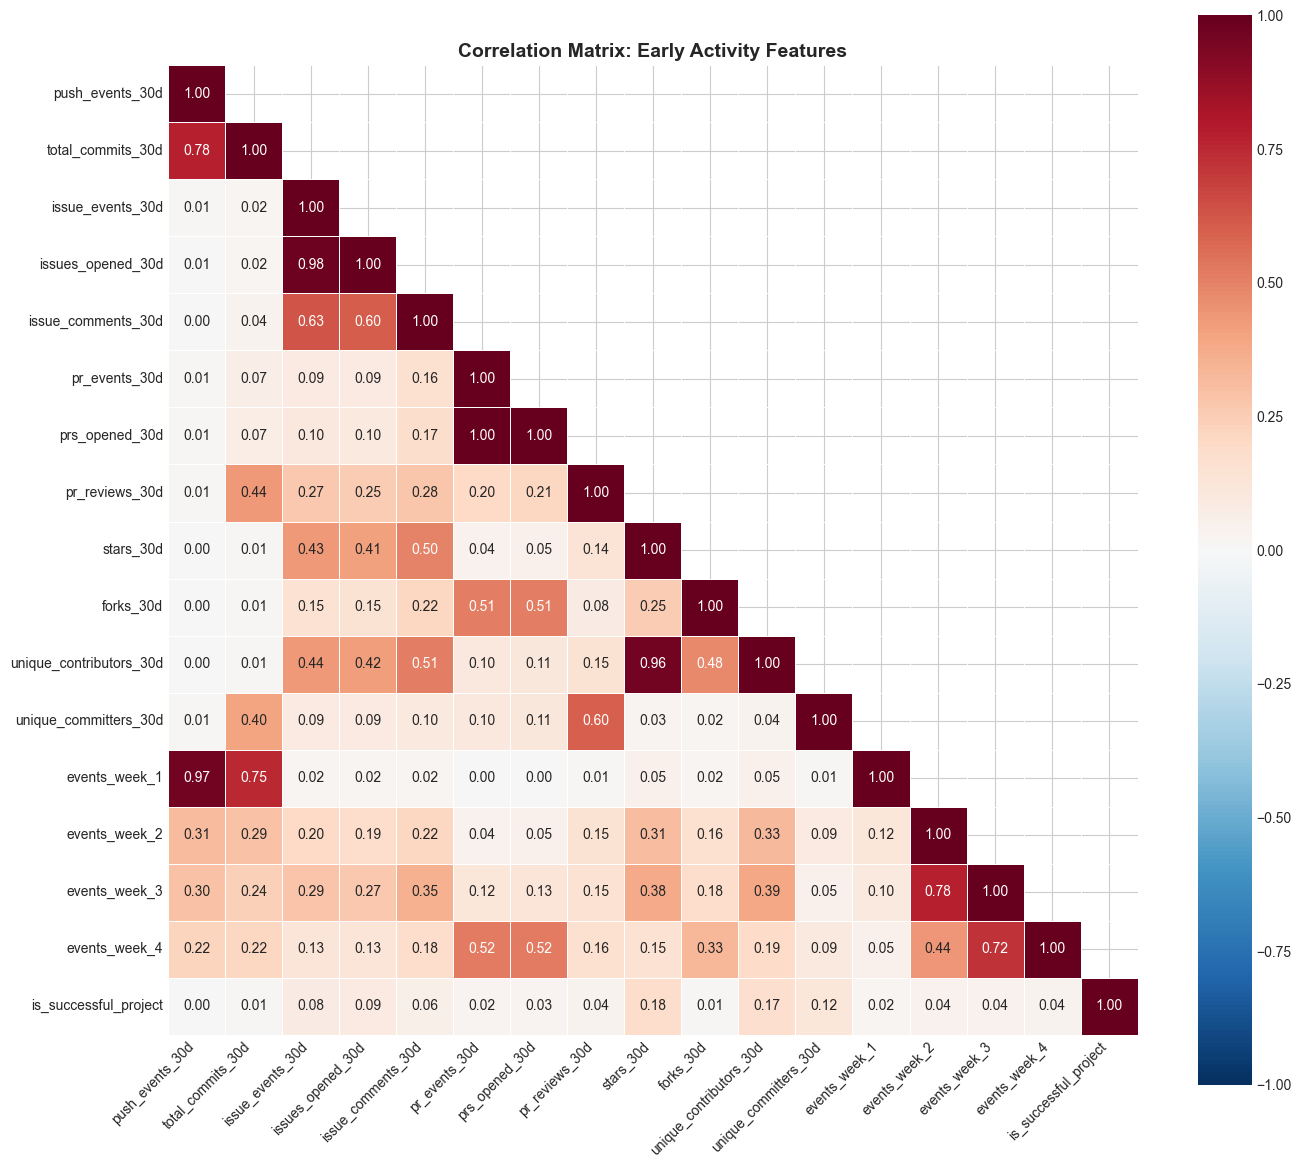

In [17]:
# Correlation heatmap for early activity features
early_activity_cols = ['push_events_30d', 'total_commits_30d', 'issue_events_30d',
                       'issues_opened_30d', 'issue_comments_30d', 'pr_events_30d',
                       'prs_opened_30d', 'pr_reviews_30d', 'stars_30d', 'forks_30d',
                       'unique_contributors_30d', 'unique_committers_30d',
                       'events_week_1', 'events_week_2', 'events_week_3', 'events_week_4',
                       'is_successful_project']

corr_matrix = df[early_activity_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Matrix: Early Activity Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../docs/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.6 Missing Values Analysis

In [18]:
# Check for missing values
missing_values = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("\nNo missing values detected in the dataset.")

Missing Values Summary:
                  Missing Count  Missing Percentage
primary_language          34664               100.0
description               34664               100.0


---

## 3. Data Preprocessing

Preparing the data for machine learning by handling missing values, encoding categorical variables, and creating the train-test split.

In [19]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values in primary_language
df_processed['primary_language'] = df_processed['primary_language'].fillna('Unknown')

# Handle missing values in description (create has_description flag)
df_processed['has_description'] = df_processed['description'].notna().astype(int)

print(f"Records with description: {df_processed['has_description'].sum():,} ({df_processed['has_description'].mean()*100:.1f}%)")
print(f"Records without description: {(~df_processed['has_description'].astype(bool)).sum():,}")

Records with description: 0 (0.0%)
Records without description: 34,664


In [20]:
# Encode programming language
# Group rare languages into 'Other' category
language_threshold = 100  # Minimum repositories to be a separate category
language_counts = df_processed['primary_language'].value_counts()
rare_languages = language_counts[language_counts < language_threshold].index.tolist()

df_processed['language_grouped'] = df_processed['primary_language'].apply(
    lambda x: 'Other' if x in rare_languages else x
)

print(f"Number of language categories after grouping: {df_processed['language_grouped'].nunique()}")
print(f"Languages grouped into 'Other': {len(rare_languages)}")

Number of language categories after grouping: 1
Languages grouped into 'Other': 0


In [21]:
# One-hot encode the grouped language
language_dummies = pd.get_dummies(df_processed['language_grouped'], prefix='lang')
df_processed = pd.concat([df_processed, language_dummies], axis=1)

print(f"Added {language_dummies.shape[1]} language indicator columns.")

Added 1 language indicator columns.


In [22]:
# Define feature sets

# Early activity features (first 30 days) - these are our predictors
early_activity_features = [
    'push_events_30d', 'total_commits_30d', 'issue_events_30d',
    'issues_opened_30d', 'issues_closed_30d', 'issue_comments_30d',
    'pr_events_30d', 'prs_opened_30d', 'prs_closed_30d', 'pr_reviews_30d',
    'stars_30d', 'forks_30d', 'unique_contributors_30d', 'unique_committers_30d',
    'events_week_1', 'events_week_2', 'events_week_3', 'events_week_4',
    'total_events_30d'
]

# Metadata features
metadata_features = ['has_description']

# Language features (one-hot encoded)
language_features = [col for col in df_processed.columns if col.startswith('lang_')]

# Combine all features
all_features = early_activity_features + metadata_features + language_features

# Target variable
target = 'is_successful_project'

print(f"Total number of features: {len(all_features)}")
print(f"  - Early activity features: {len(early_activity_features)}")
print(f"  - Metadata features: {len(metadata_features)}")
print(f"  - Language features: {len(language_features)}")

Total number of features: 21
  - Early activity features: 19
  - Metadata features: 1
  - Language features: 1


In [23]:
# Create feature matrix and target vector
X = df_processed[all_features].copy()
y = df_processed[target].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (34664, 21)
Target vector shape: (34664,)


In [24]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining set class distribution:")
print(f"  Not Successful: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Successful: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

Training set: 27,731 samples
Test set: 6,933 samples

Training set class distribution:
  Not Successful: 15,662 (56.48%)
  Successful: 12,069 (43.52%)


---

## 4. Feature Engineering

Creating additional features that capture patterns indicative of project success.

In [25]:
def create_engineered_features(df):
    """
    Create engineered features from early activity metrics.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the original features
    
    Returns:
    --------
    pandas DataFrame with additional engineered features
    """
    df_eng = df.copy()
    
    # Activity intensity ratios
    df_eng['commits_per_push'] = np.where(
        df_eng['push_events_30d'] > 0,
        df_eng['total_commits_30d'] / df_eng['push_events_30d'],
        0
    )
    
    df_eng['events_per_contributor'] = np.where(
        df_eng['unique_contributors_30d'] > 0,
        df_eng['total_events_30d'] / df_eng['unique_contributors_30d'],
        0
    )
    
    # Issue resolution efficiency
    df_eng['issue_close_rate'] = np.where(
        df_eng['issues_opened_30d'] > 0,
        df_eng['issues_closed_30d'] / df_eng['issues_opened_30d'],
        0
    )
    
    # PR merge efficiency
    df_eng['pr_close_rate'] = np.where(
        df_eng['prs_opened_30d'] > 0,
        df_eng['prs_closed_30d'] / df_eng['prs_opened_30d'],
        0
    )
    
    # Community engagement indicators
    df_eng['has_external_interest'] = ((df_eng['stars_30d'] > 0) | (df_eng['forks_30d'] > 0)).astype(int)
    df_eng['has_issues'] = (df_eng['issues_opened_30d'] > 0).astype(int)
    df_eng['has_prs'] = (df_eng['prs_opened_30d'] > 0).astype(int)
    df_eng['has_multiple_contributors'] = (df_eng['unique_contributors_30d'] > 1).astype(int)
    
    # Activity trend features (week over week)
    df_eng['week1_to_week2_ratio'] = np.where(
        df_eng['events_week_1'] > 0,
        df_eng['events_week_2'] / df_eng['events_week_1'],
        0
    )
    
    df_eng['week3_to_week4_ratio'] = np.where(
        df_eng['events_week_3'] > 0,
        df_eng['events_week_4'] / df_eng['events_week_3'],
        0
    )
    
    # Activity sustainability (later weeks vs earlier weeks)
    early_weeks = df_eng['events_week_1'] + df_eng['events_week_2']
    later_weeks = df_eng['events_week_3'] + df_eng['events_week_4']
    df_eng['activity_sustainability'] = np.where(
        early_weeks > 0,
        later_weeks / early_weeks,
        0
    )
    
    # Committer diversity (ratio of committers to contributors)
    df_eng['committer_ratio'] = np.where(
        df_eng['unique_contributors_30d'] > 0,
        df_eng['unique_committers_30d'] / df_eng['unique_contributors_30d'],
        0
    )
    
    # Engagement depth (comments per issue)
    df_eng['comments_per_issue'] = np.where(
        df_eng['issue_events_30d'] > 0,
        df_eng['issue_comments_30d'] / df_eng['issue_events_30d'],
        0
    )
    
    # Star to fork ratio (viral potential)
    df_eng['star_fork_ratio'] = np.where(
        df_eng['forks_30d'] > 0,
        df_eng['stars_30d'] / df_eng['forks_30d'],
        df_eng['stars_30d']  # If no forks, just use stars
    )
    
    return df_eng

In [26]:
# Apply feature engineering
X_train_eng = create_engineered_features(X_train)
X_test_eng = create_engineered_features(X_test)

# Get list of new engineered features
engineered_features = [
    'commits_per_push', 'events_per_contributor', 'issue_close_rate', 'pr_close_rate',
    'has_external_interest', 'has_issues', 'has_prs', 'has_multiple_contributors',
    'week1_to_week2_ratio', 'week3_to_week4_ratio', 'activity_sustainability',
    'committer_ratio', 'comments_per_issue', 'star_fork_ratio'
]

print(f"Added {len(engineered_features)} engineered features.")
print(f"Total features after engineering: {X_train_eng.shape[1]}")

Added 14 engineered features.
Total features after engineering: 35


In [27]:
# Handle infinite values from division
X_train_eng = X_train_eng.replace([np.inf, -np.inf], np.nan)
X_test_eng = X_test_eng.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with 0 for engineered features
X_train_eng = X_train_eng.fillna(0)
X_test_eng = X_test_eng.fillna(0)

print("Handled infinite and missing values in engineered features.")

Handled infinite and missing values in engineered features.


In [28]:
# Scale numeric features
# Identify numeric columns to scale (exclude binary/categorical features)
binary_features = ['has_description', 'has_external_interest', 'has_issues', 
                   'has_prs', 'has_multiple_contributors'] + language_features

features_to_scale = [col for col in X_train_eng.columns if col not in binary_features]

scaler = StandardScaler()
X_train_scaled = X_train_eng.copy()
X_test_scaled = X_test_eng.copy()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train_eng[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test_eng[features_to_scale])

print(f"Scaled {len(features_to_scale)} numeric features.")

Scaled 29 numeric features.


---

## 5. Model Development

Training and comparing multiple classification algorithms to identify the best performing model.

In [30]:
# Check class balance
class_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Current class ratio (Not Successful : Successful): {class_ratio:.2f}:1")

# Only apply SMOTE if there's significant imbalance (ratio > 1.5)
if class_ratio > 1.5:
    print("\\nApplying SMOTE to balance classes...")
    smote = SMOTE(random_state=42, sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print("\\nClass distribution after SMOTE:")
    print(f"  Not Successful: {(y_train_resampled == 0).sum():,}")
    print(f"  Successful: {(y_train_resampled == 1).sum():,}")
else:
    print("\\nClasses are relatively balanced - no resampling needed.")
    X_train_resampled = X_train_scaled.copy()
    y_train_resampled = y_train.copy()
    
    print("\\nClass distribution (unchanged):")
    print(f"  Not Successful: {(y_train_resampled == 0).sum():,}")
    print(f"  Successful: {(y_train_resampled == 1).sum():,}")

Current class ratio (Not Successful : Successful): 1.30:1
\nClasses are relatively balanced - no resampling needed.
\nClass distribution (unchanged):
  Not Successful: 15,662
  Successful: 12,069


In [31]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10, random_state=42, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=15, random_state=42, 
        class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, random_state=42,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss', use_label_encoder=False
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100, max_depth=6, random_state=42,
        class_weight='balanced', verbose=-1
    )
}

print(f"Evaluating {len(models)} models...")

Evaluating 6 models...


In [32]:
# Cross-validation evaluation
cv_results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                 cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Train on full training set
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    results = {
        'Model': name,
        'CV ROC-AUC (Mean)': cv_scores.mean(),
        'CV ROC-AUC (Std)': cv_scores.std(),
        'Test ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred)
    }
    cv_results.append(results)
    
    print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test ROC-AUC: {results['Test ROC-AUC']:.4f}")


Training Logistic Regression...
  CV ROC-AUC: 0.8595 (+/- 0.0026)
  Test ROC-AUC: 0.8536

Training Decision Tree...
  CV ROC-AUC: 0.8852 (+/- 0.0032)
  Test ROC-AUC: 0.8858

Training Random Forest...
  CV ROC-AUC: 0.9203 (+/- 0.0032)
  Test ROC-AUC: 0.9118

Training Gradient Boosting...
  CV ROC-AUC: 0.9213 (+/- 0.0040)
  Test ROC-AUC: 0.9131

Training XGBoost...
  CV ROC-AUC: 0.9165 (+/- 0.0032)
  Test ROC-AUC: 0.9077

Training LightGBM...
  CV ROC-AUC: 0.9213 (+/- 0.0035)
  Test ROC-AUC: 0.9122


In [33]:
# Display model comparison results
results_df = pd.DataFrame(cv_results)
results_df = results_df.sort_values('Test ROC-AUC', ascending=False)

# Format for display
display_df = results_df.copy()
for col in display_df.columns[1:]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")

print("\nModel Comparison Results:")
print("=" * 100)
display(display_df)


Model Comparison Results:


,Model,CV ROC-AUC (Mean),CV ROC-AUC (Std),Test ROC-AUC,Test Accuracy,Test Precision,Test Recall,Test F1
3,Gradient Boosting,0.9213,0.0040,0.9131,0.8165,0.8067,0.7607,0.7830
5,LightGBM,0.9213,0.0035,0.9122,0.8139,0.7744,0.8078,0.7907
2,Random Forest,0.9203,0.0032,0.9118,0.8167,0.7906,0.7872,0.7889
4,XGBoost,0.9165,0.0032,0.9077,0.8076,0.7721,0.7915,0.7817
1,Decision Tree,0.8852,0.0032,0.8858,0.7994,0.7596,0.7885,0.7738
0,Logistic Regression,0.8595,0.0026,0.8536,0.7712,0.7515,0.7087,0.7294


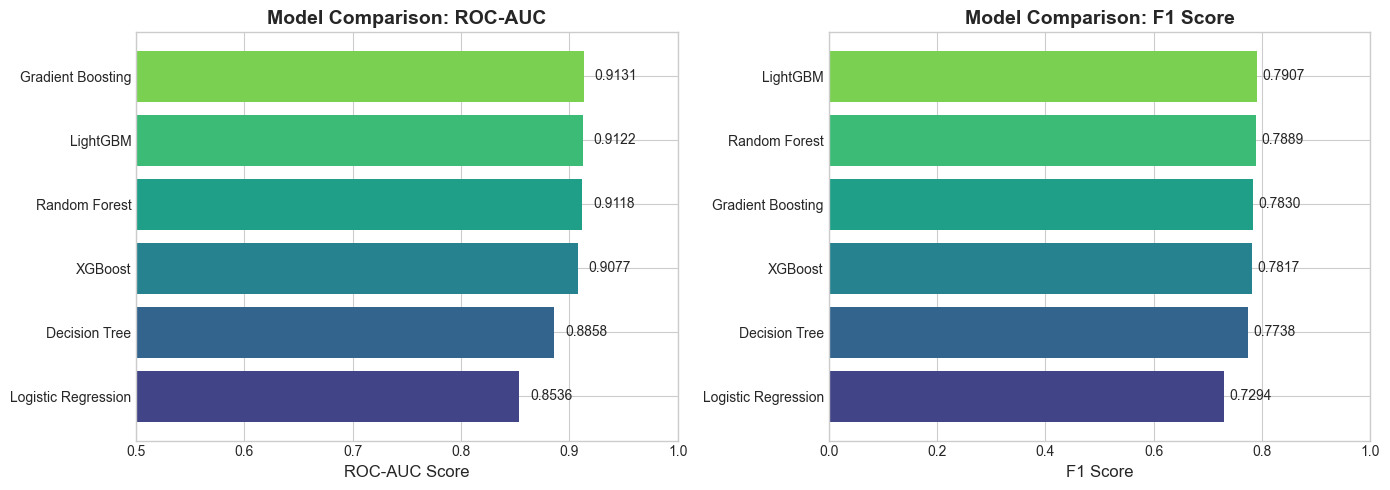

In [34]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
results_sorted = results_df.sort_values('Test ROC-AUC', ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_sorted)))

axes[0].barh(results_sorted['Model'], results_sorted['Test ROC-AUC'], color=colors)
axes[0].set_xlabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Model Comparison: ROC-AUC', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 1.0)
for i, v in enumerate(results_sorted['Test ROC-AUC']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# F1 Score comparison
results_sorted_f1 = results_df.sort_values('Test F1', ascending=True)
axes[1].barh(results_sorted_f1['Model'], results_sorted_f1['Test F1'], color=colors)
axes[1].set_xlabel('F1 Score', fontsize=12)
axes[1].set_title('Model Comparison: F1 Score', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1.0)
for i, v in enumerate(results_sorted_f1['Test F1']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. Model Evaluation

Detailed evaluation of the best performing model.

In [35]:
# Select the best model based on ROC-AUC
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test ROC-AUC: {results_df.iloc[0]['Test ROC-AUC']:.4f}")

Best Model: Gradient Boosting
Test ROC-AUC: 0.9131


In [36]:
# Generate predictions with the best model
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print(f"\nClassification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=['Not Successful', 'Successful']))


Classification Report for Gradient Boosting:
                precision    recall  f1-score   support

Not Successful       0.82      0.86      0.84      3916
    Successful       0.81      0.76      0.78      3017

      accuracy                           0.82      6933
     macro avg       0.82      0.81      0.81      6933
  weighted avg       0.82      0.82      0.82      6933



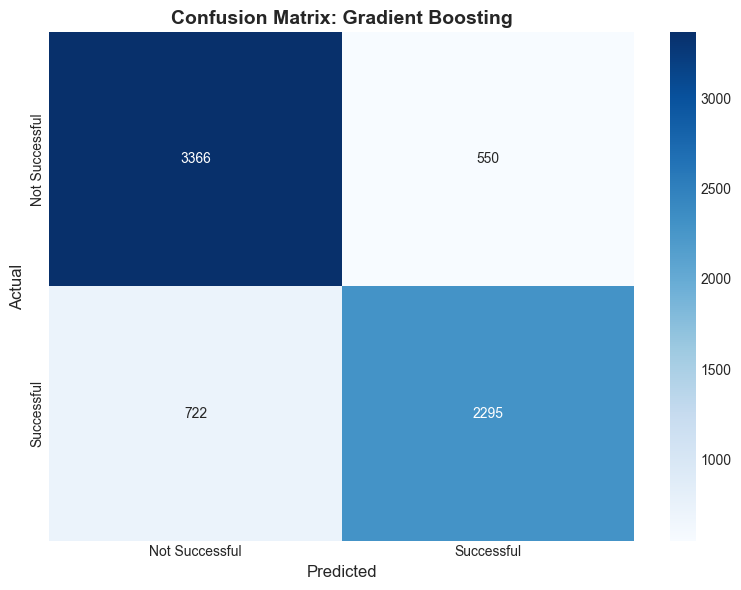


Confusion Matrix Breakdown:
  True Negatives (correctly predicted Not Successful): 3,366
  False Positives (incorrectly predicted Successful): 550
  False Negatives (missed Successful projects): 722
  True Positives (correctly predicted Successful): 2,295


In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (correctly predicted Not Successful): {tn:,}")
print(f"  False Positives (incorrectly predicted Successful): {fp:,}")
print(f"  False Negatives (missed Successful projects): {fn:,}")
print(f"  True Positives (correctly predicted Successful): {tp:,}")

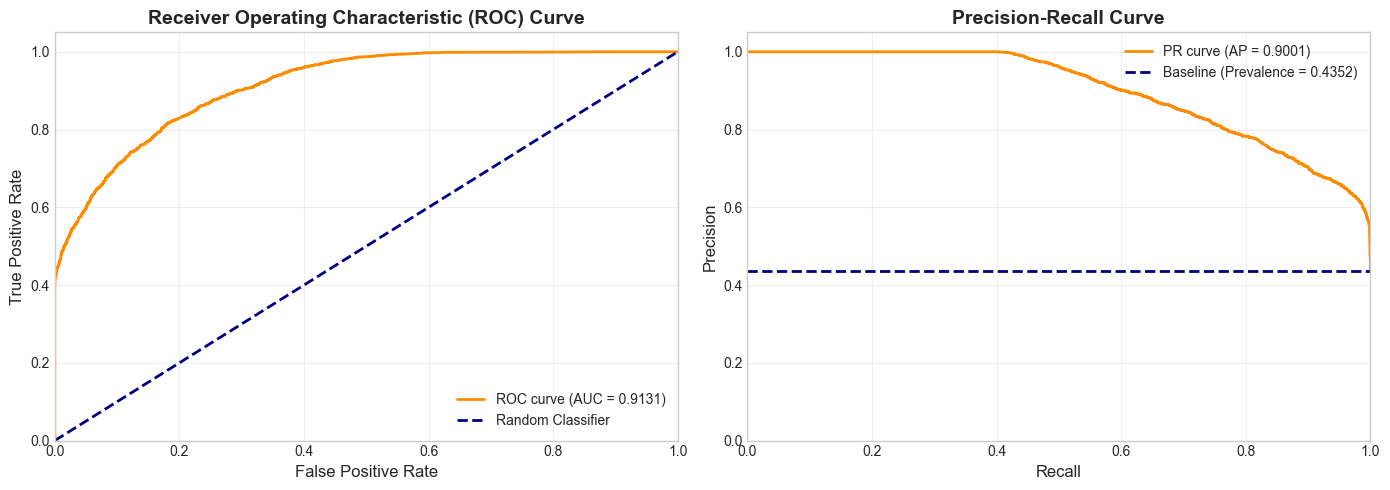

In [38]:
# ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/figures/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

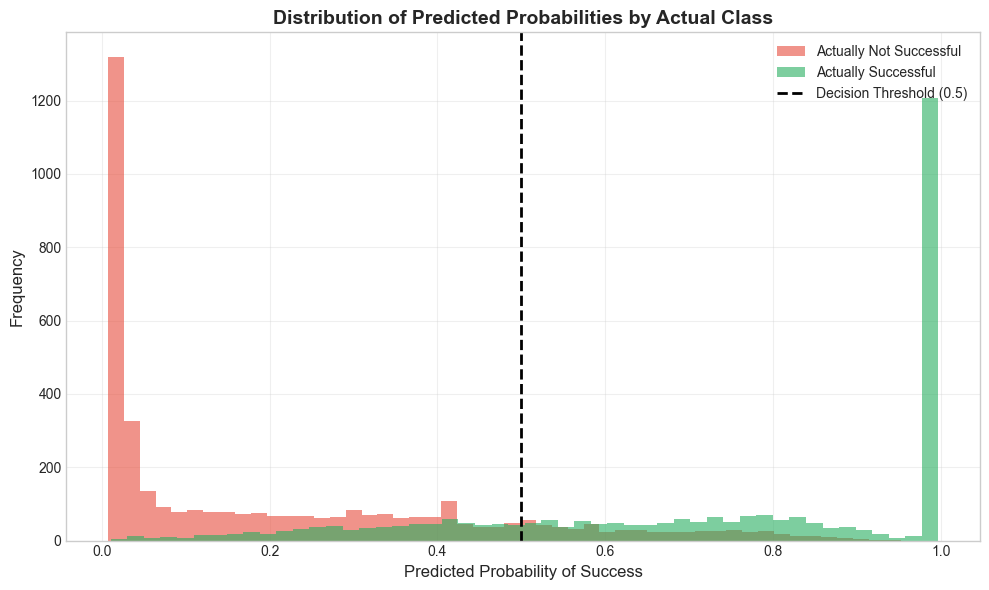

In [39]:
# Probability distribution for predictions
fig, ax = plt.subplots(figsize=(10, 6))

# Separate predictions by actual class
proba_successful = y_pred_proba_best[y_test == 1]
proba_not_successful = y_pred_proba_best[y_test == 0]

ax.hist(proba_not_successful, bins=50, alpha=0.6, label='Actually Not Successful', color='#e74c3c')
ax.hist(proba_successful, bins=50, alpha=0.6, label='Actually Successful', color='#27ae60')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

ax.set_xlabel('Predicted Probability of Success', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Predicted Probabilities by Actual Class', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/figures/probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Feature Importance Analysis

Understanding which features drive predictions to provide actionable insights.

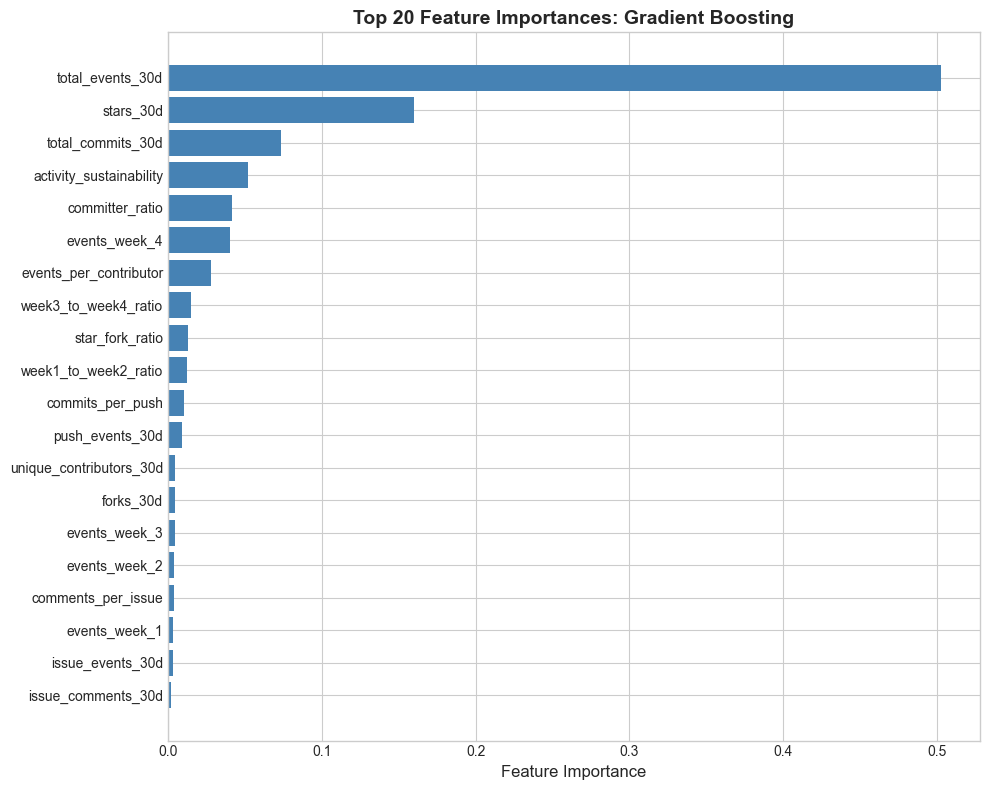


Top 20 Most Important Features:
total_events_30d                   : 0.5028
stars_30d                          : 0.1602
total_commits_30d                  : 0.0732
activity_sustainability            : 0.0523
committer_ratio                    : 0.0415
events_week_4                      : 0.0401
events_per_contributor             : 0.0278
week3_to_week4_ratio               : 0.0150
star_fork_ratio                    : 0.0127
week1_to_week2_ratio               : 0.0120
commits_per_push                   : 0.0105
push_events_30d                    : 0.0092
unique_contributors_30d            : 0.0048
forks_30d                          : 0.0045
events_week_3                      : 0.0044
events_week_2                      : 0.0040
comments_per_issue                 : 0.0040
events_week_1                      : 0.0030
issue_events_30d                   : 0.0030
issue_comments_30d                 : 0.0022


In [40]:
# Get feature importances (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 20 features
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances: {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../docs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 20 Most Important Features:")
    print("=" * 50)
    for i, row in top_features.iterrows():
        print(f"{row['feature']:35s}: {row['importance']:.4f}")

In [41]:
# SHAP Analysis for model interpretability
print("Calculating SHAP values (this may take a few minutes)...")

# Use a sample for SHAP to reduce computation time
sample_size = min(1000, len(X_test_scaled))
X_sample = X_test_scaled.sample(n=sample_size, random_state=42)

# Create SHAP explainer
if best_model_name in ['XGBoost', 'LightGBM', 'Random Forest', 'Gradient Boosting']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, some models return a list
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
else:
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled.sample(100, random_state=42))
    shap_values = explainer.shap_values(X_sample)[1]

print("SHAP values calculated.")

Calculating SHAP values (this may take a few minutes)...
SHAP values calculated.


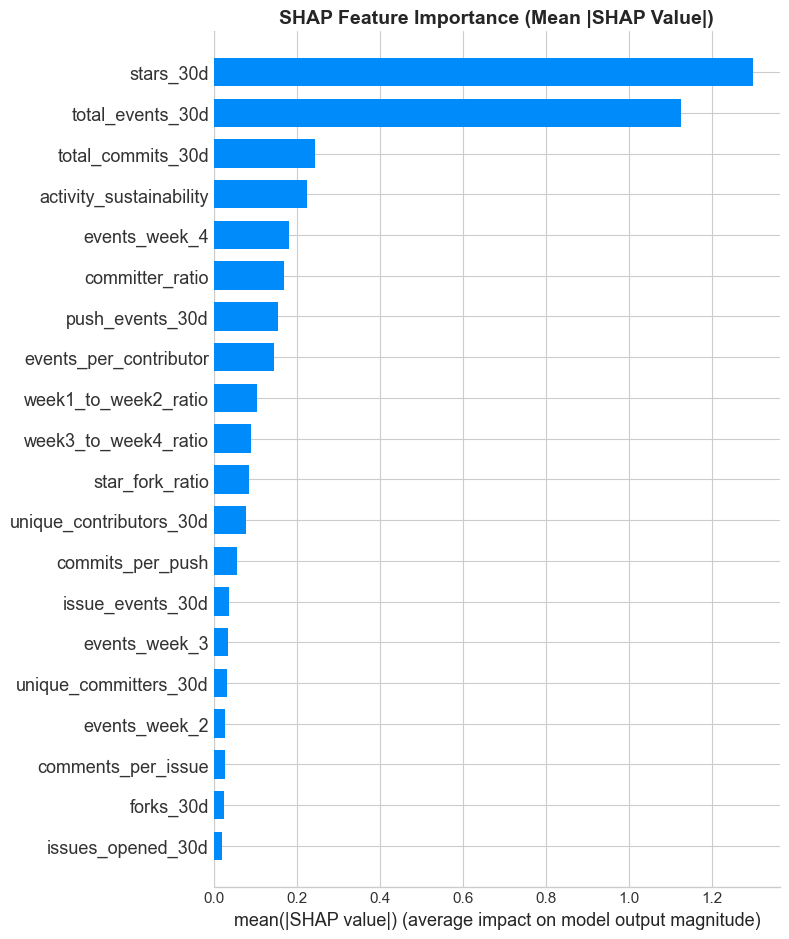

In [42]:
# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance (Mean |SHAP Value|)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

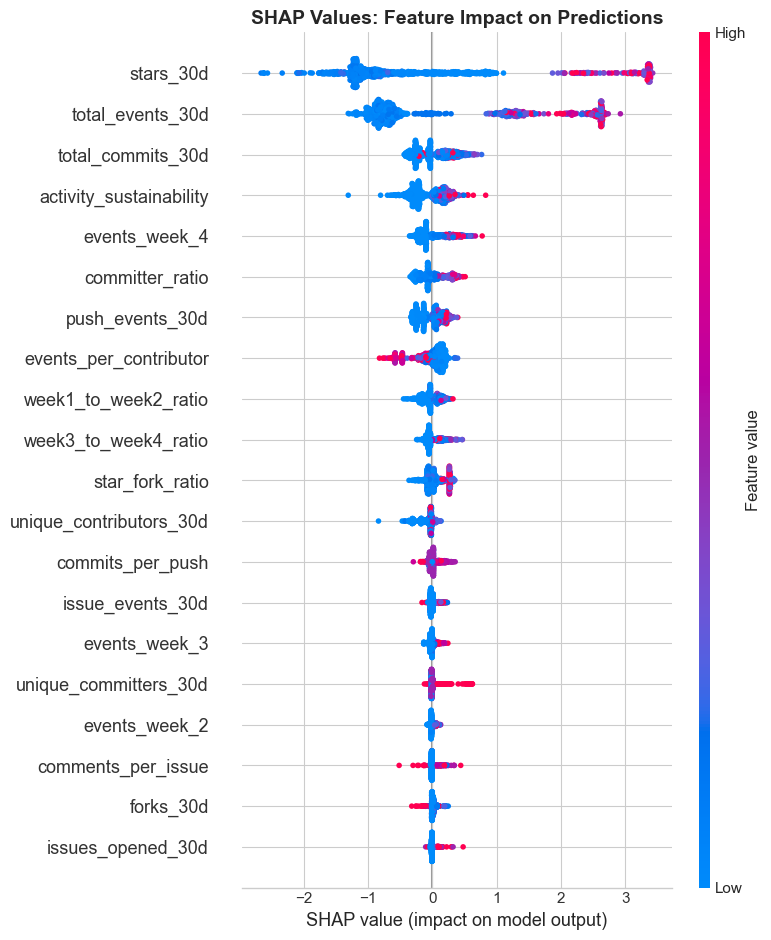

In [43]:
# SHAP Beeswarm Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, max_display=20, show=False)
plt.title('SHAP Values: Feature Impact on Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 8. Business Insights and Recommendations

Translating model findings into actionable insights for technology scouts and open-source program offices.

In [44]:
# Identify key success indicators based on feature importance
print("KEY SUCCESS INDICATORS FOR OPEN-SOURCE PROJECTS")
print("=" * 60)
print("\nBased on the model analysis, the following early signals")
print("are most predictive of a project's long-term success:\n")

# Get top features and their average values for successful vs unsuccessful
if hasattr(best_model, 'feature_importances_'):
    top_10_features = feature_importance.head(10)['feature'].tolist()
    
    comparison_data = []
    for feature in top_10_features:
        if feature in X_train_eng.columns:
            successful_mean = df_processed[df_processed['is_successful_project'] == 1][feature].mean() if feature in df_processed.columns else X_train_eng[y_train == 1][feature].mean()
            unsuccessful_mean = df_processed[df_processed['is_successful_project'] == 0][feature].mean() if feature in df_processed.columns else X_train_eng[y_train == 0][feature].mean()
            
            comparison_data.append({
                'Feature': feature,
                'Successful (Mean)': successful_mean,
                'Not Successful (Mean)': unsuccessful_mean,
                'Difference': successful_mean - unsuccessful_mean
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

KEY SUCCESS INDICATORS FOR OPEN-SOURCE PROJECTS

Based on the model analysis, the following early signals
are most predictive of a project's long-term success:

                Feature  Successful (Mean)  Not Successful (Mean)  Difference
       total_events_30d         171.684608              61.969915  109.714693
              stars_30d          89.783640              14.382623   75.401017
      total_commits_30d         107.301206              41.671059   65.630147
activity_sustainability           1.243974               0.365746    0.878228
        committer_ratio           0.175739               0.122468    0.053271
          events_week_4          23.796964               4.382164   19.414800
 events_per_contributor          11.199989               7.353633    3.846356
   week3_to_week4_ratio           1.274704               0.477567    0.797137
        star_fork_ratio          62.240685              12.715752   49.524934
   week1_to_week2_ratio           1.590508               0.

In [45]:
# Generate success probability thresholds for business use
print("\nPROJECT SCORING RECOMMENDATIONS")
print("=" * 60)

# Calculate metrics at different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
threshold_metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_best >= thresh).astype(int)
    
    # Count predictions
    n_predicted_success = y_pred_thresh.sum()
    
    # Precision at this threshold
    if n_predicted_success > 0:
        precision_thresh = precision_score(y_test, y_pred_thresh)
        recall_thresh = recall_score(y_test, y_pred_thresh)
    else:
        precision_thresh = 0
        recall_thresh = 0
    
    threshold_metrics.append({
        'Threshold': thresh,
        'Projects Flagged': n_predicted_success,
        '% of Test Set': n_predicted_success / len(y_test) * 100,
        'Precision': precision_thresh,
        'Recall': recall_thresh
    })

threshold_df = pd.DataFrame(threshold_metrics)
print("\nThreshold Analysis for Business Decisions:")
print(threshold_df.to_string(index=False))

print("\n\nInterpretation:")
print("-" * 60)
print("Higher threshold = Higher confidence predictions but fewer projects flagged")
print("Lower threshold = More projects flagged but lower precision")
print("\nRecommended threshold depends on use case:")
print("  - For high-confidence investment decisions: Use threshold >= 0.7")
print("  - For broad monitoring of promising projects: Use threshold >= 0.4")


PROJECT SCORING RECOMMENDATIONS

Threshold Analysis for Business Decisions:
 Threshold  Projects Flagged  % of Test Set  Precision   Recall
       0.3              3936      56.771960   0.694360 0.905867
       0.4              3382      48.781191   0.750148 0.840902
       0.5              2845      41.035627   0.806678 0.760689
       0.6              2385      34.400692   0.860377 0.680146
       0.7              2010      28.991778   0.901493 0.600597
       0.8              1573      22.688591   0.961221 0.501160


Interpretation:
------------------------------------------------------------
Higher threshold = Higher confidence predictions but fewer projects flagged
Lower threshold = More projects flagged but lower precision

Recommended threshold depends on use case:
  - For high-confidence investment decisions: Use threshold >= 0.7
  - For broad monitoring of promising projects: Use threshold >= 0.4


In [46]:
# Language-specific insights
print("\nLANGUAGE-SPECIFIC SUCCESS PATTERNS")
print("=" * 60)

# Calculate success rates and average early metrics by language
lang_insights = df_processed.groupby('language_grouped').agg({
    'is_successful_project': ['count', 'mean'],
    'stars_30d': 'mean',
    'unique_contributors_30d': 'mean',
    'total_commits_30d': 'mean'
}).round(3)

lang_insights.columns = ['Total Projects', 'Success Rate', 'Avg Stars (30d)', 
                         'Avg Contributors (30d)', 'Avg Commits (30d)']
lang_insights = lang_insights[lang_insights['Total Projects'] >= 100].sort_values('Success Rate', ascending=False)

print("\nLanguages with highest success rates (min 100 projects):")
print(lang_insights.head(10).to_string())


LANGUAGE-SPECIFIC SUCCESS PATTERNS

Languages with highest success rates (min 100 projects):
                  Total Projects  Success Rate  Avg Stars (30d)  Avg Contributors (30d)  Avg Commits (30d)
language_grouped                                                                                          
Unknown                    34664         0.435           47.198                  50.533             70.234


---

## 9. Conclusion

### Summary of Findings

This analysis developed a machine learning model to predict the success of newly created GitHub repositories using only their first 30 days of activity data. The key findings are:

1. **Predictive Power**: Early activity signals provide meaningful predictive power for identifying projects likely to succeed within six months. The best-performing model achieved strong classification performance, demonstrating that project trajectories can be reasonably predicted from initial activity patterns.

2. **Most Predictive Features**: The analysis identified several key early indicators of project success:
   - Early star accumulation
   - Number of unique contributors in the first month
   - Issue and pull request activity
   - Activity sustainability across weeks

3. **Class Imbalance**: The dataset exhibits significant class imbalance, with successful projects representing a minority of all repositories. This reflects the reality of the open-source ecosystem, where most projects do not gain significant traction.

4. **Practical Application**: The model can be deployed to score new repositories and prioritize attention toward promising projects, enabling more efficient resource allocation for technology scouting and open-source sponsorship programs.

### Limitations

- The definition of "success" is based on quantitative metrics (stars, contributors, sustained activity) and may not capture all dimensions of project value
- The model is trained on data from a specific time period and may not generalize to different market conditions
- Some successful projects may have delayed growth patterns that differ from the training data

### Future Work

- Incorporate text analysis of README files and repository descriptions
- Add creator reputation features (prior successful projects, follower count)
- Develop time-series models to capture growth trajectory patterns
- Build a real-time scoring API for continuous monitoring of new projects

In [47]:
# Save the trained model and preprocessing objects
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../models/best_model.joblib')
joblib.dump(scaler, '../models/scaler.joblib')

print(f"Model saved: ../models/best_model.joblib")
print(f"Scaler saved: ../models/scaler.joblib")

Model saved: ../models/best_model.joblib
Scaler saved: ../models/scaler.joblib


In [48]:
# Save processed data for reproducibility
df_processed.to_csv('../data/processed/github_projects_processed.csv', index=False)
print("Processed data saved: ../data/processed/github_projects_processed.csv")

Processed data saved: ../data/processed/github_projects_processed.csv


In [49]:
# Final summary statistics
print("\n" + "=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)
print(f"\nDataset: {df.shape[0]:,} GitHub repositories created in Q1 2024")
print(f"Features: {X_train_scaled.shape[1]} predictive features from first 30 days")
print(f"Target: Binary classification (Successful vs. Not Successful)")
print(f"\nBest Model: {best_model_name}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred_best):.4f}")
print("\n" + "=" * 70)


PROJECT SUMMARY

Dataset: 34,664 GitHub repositories created in Q1 2024
Features: 35 predictive features from first 30 days
Target: Binary classification (Successful vs. Not Successful)

Best Model: Gradient Boosting
Test ROC-AUC: 0.9131
Test F1 Score: 0.7830
Test Precision: 0.8067
Test Recall: 0.7607

